In [200]:
# Import libraries

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import geopandas as gpd
import glob
import re
import matplotlib.font_manager as font_manager

In [201]:
# Import CSV files for yearly IFC disclosure data

path = r'/Users/jsmasood/Documents/CGD/IFC/' # Create a path
all_files = glob.glob(path + "Input/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding='latin-1')
    li.append(df)

df_allifc = pd.concat(li, axis=0, ignore_index=True)

# Filter by project status

df_allifc = df_allifc[(df_allifc['Status Description'] == 'Active') | ((df_allifc['Status Description'] == 'Completed'))]

# Filter by document type

df_allifc = df_allifc[df_allifc['Document Type Description']!='Environmental Documents']

In [202]:
# Keep relevant columns

df_ifc = df_allifc.iloc[:,np.r_[0:2,3,5, 7:10, 11, 26, 33, 35]]

# Check for missing values

df_ifc.isnull().sum(axis = 0)

# Convert columns to date type

df_ifc.loc[:,('Disclosed Date')] = pd.to_datetime(df_ifc['Disclosed Date'])
df_ifc.loc[:,('Projected Board Date')] = pd.to_datetime(df_ifc['Projected Board Date'])

# Extract years

df_ifc.loc[:,('year')] = df_ifc.loc[:,('Projected Board Date')].dt.year
df_ifc.loc[:,('year')] = df_ifc.loc[:,('year')].fillna(df_ifc.loc[:,('Disclosed Date')].dt.year)

# Extract total amount from Investment string

df_ifc.loc[:,('Total Amount')] = df_ifc.Investment.str.split(" ", n=1, expand = True)[0]
df_ifc.loc[:,('Total Amount')] = df_ifc['Total Amount'].astype(float)

# Add in inflation data and calculate rate in 2019 $

infl = pd.read_excel(path + "/Input/inflation.xlsx")

df_ifc = df_ifc.merge(infl, how = 'left', left_on='year', right_on='Year')

df_ifc['Amount_infl'] = df_ifc['Total Amount'] * df_ifc['Rate_2019']

# Delete project from 2020

df_ifc.drop(df_ifc[df_ifc['year'] == 2020].index, inplace=True)

/Users/jsmasood/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jsmasood/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [203]:
# Seperate investment projects

df_inv = df_ifc[df_ifc['Type Description']=='Investment']

# Import additional investment projects dataset

inv = pd.read_csv('IFC_Investment_Services_Projects.csv')

# Filter by project status

inv = inv[(inv['Status'] == 'Active') | ((inv['Status'] == 'Completed'))]

# Convert columns to date type

inv.loc[:,('Disclosed Date')] = pd.to_datetime(inv['Disclosed Date'])
inv.loc[:,('Projected Board Date')] = pd.to_datetime(inv['Projected Board Date'])

# Extract years

inv.loc[:,('year')] = inv.loc[:,('Projected Board Date')].dt.year
inv.loc[:,('year')] = inv.loc[:,('year')].fillna(df_inv.loc[:,('Disclosed Date')].dt.year)

# Subset relevant columns

inv2 = inv.iloc[:,np.r_[3 ,5, 7:10, 12:15, 17:23, 27]]

# Merge both investment datasets

final_inv = df_inv.merge(inv2, left_on = 'Project Number', right_on = 'Project Number', how = 'left', indicator = True)

In [204]:
# Add in country codes using World Bank codebook

ccodes = pd.read_excel(path + "/WB Data/ISO3 Ccodes.xlsx")

# Delete whitespaces (coding as xa0 in latin encoding)

ccodes['Country Name'] = ccodes['Country Name'].str.replace(u'\xa0', u'')

ccodes_dict = dict(zip(ccodes['Country Name'], ccodes['ISO3']))

final_inv['Country_Code'] = final_inv['Country Description']

final_inv = final_inv.replace({"Country_Code": ccodes_dict})

final_inv['Country_Code'] = final_inv['Country_Code'].str.replace(u'\xa0', u'')

In [205]:
# In order to discover which countries have not yet been categorized and need to be manually
# recoded we can create a new dataframe with all the rows with Code longer than 3 characters

Ccodes_unmatched = final_inv[final_inv['Country_Code'].str.len() > 3]

# Get summary of values

Ccodes_unmatched_counts = Ccodes_unmatched['Country_Code'].value_counts().reset_index()

# Remove codes matched correctly

Ccodes_unmatched_summary = Ccodes_unmatched_counts[~Ccodes_unmatched_counts['index'].str.contains("Region")]

# Add in codes for the 19 rows manually

codes_list = ['EGY', 'SRB', 'CIV', 'ETH', 'LAO', 'ZAR', 'RKS', 'GAZ', 'MKD', 'MNE', 'VEN', 'YEM', '', 'KOR', 'HKG', 'TMP', 'IRN', 'SSD', 'COG']

# Create a dictionary to remap incorrectly matched codes

cnames_list = Ccodes_unmatched_summary['index'].tolist()

ccodes_correction_dict = dict(zip(cnames_list, codes_list))

# Use this to replace values in main dataframe

final_inv = final_inv.replace({"Country_Code": ccodes_correction_dict})

# Add in preferred names (simple to recall as opposed to official)

ccodes2 = pd.read_stata(path + "/WB Data/CCodes.dta")

# Subset and merge in data

ccodes2 = ccodes2.iloc[:,[8,11]].drop_duplicates()

final_inv = final_inv.merge(ccodes2, left_on = 'Country_Code', right_on = 'iso_ccode', how = 'left')

In [206]:
# Create a dataframe with country summaries of amounts recieved and relevant WB data to plot maps

cntry_amnts = pd.DataFrame(final_inv['Amount_infl'].groupby(final_inv['preferred_name']).sum()).reset_index()

cntry_amnts.sort_values(by=['Amount_infl'], ascending = False)

# Create a df with all countries to plot

map_data = ccodes2.merge(cntry_amnts, right_on = 'preferred_name', left_on = 'preferred_name', how = 'left')

# Import GDP, Population and Credit Depth Data

gdp = pd.read_csv(path + "/WB Data/WB_GDP.csv")
gdp = gdp.drop(['Country Name', 'Indicator Name'], axis=1)
gdp = gdp.add_prefix('gdp_')
gdp = gdp.rename(columns={'gdp_Country Code': 'Country Code'})
gdp.drop(gdp.columns[1:18], axis = 1, inplace = True)


pop = pd.read_csv(path + "/WB Data/WB_POP.csv")
pop = pop.drop(['Country Name', 'Indicator Name'], axis=1)
pop = pop.add_prefix('pop_')
pop = pop.rename(columns={'pop_Country Code': 'Country Code'})
pop.drop(pop.columns[1:18], axis = 1, inplace = True)


crd = pd.read_csv(path + "/WB Data/WB_CRD.csv")
crd = crd.drop(['Country Name', 'Indicator Name'], axis=1)
crd = crd.add_prefix('crd_')
crd = crd.rename(columns={'crd_Country Code': 'Country Code'})
crd.drop(crd.columns[1:18], axis = 1, inplace = True)

gdppc = pd.read_excel(path + "/WB Data/GDP_PC.xls")
gdppc = gdppc.drop(['Country Name'], axis=1)
gdppc = gdppc.add_prefix('gdppc_')
gdppc = gdppc.rename(columns={'gdppc_Country Code': 'Country Code'})
gdppc.drop(gdppc.columns[1:18], axis = 1, inplace = True)

# Merge with map data

map_data = map_data.merge(gdp, how = 'left', left_on='iso_ccode', right_on='Country Code')
map_data = map_data.merge(pop, how = 'left', left_on='iso_ccode', right_on='Country Code')
map_data = map_data.merge(crd, how = 'left', left_on='iso_ccode', right_on='Country Code')
map_data = map_data.merge(gdppc, how = 'left', left_on='iso_ccode', right_on='Country Code')

# Delete rows which we can't show on map (regional projects and Yugoslavia)

map_data.drop(map_data.index[0], inplace = True)

df_ifc.drop(df_ifc[df_ifc['year'] == 2020].index, inplace=True)

# Countries with missing values for IFC funds recieved no funds

map_data['Amount_infl'] = map_data['Amount_infl'].fillna(0)

# Calculate IFC spend per population and per $1000 of GDP per capita

map_data.isnull().sum(axis = 0)

map_data['funds_per_pop'] = map_data['Amount_infl'] / map_data['pop_2018']

map_data['funds_per_pop'] = map_data['funds_per_pop'].fillna(0)

map_data['funds_per_gdp'] = map_data['Amount_infl'] / map_data['gdppc_2018']

map_data['funds_per_gdp'] = map_data['funds_per_gdp'].fillna(0)

# map_data['funds_per_gdp'] = map_data['Amount_infl'] / (map_data['gdp_2018'] / (1000*map_data['pop_2018']))

# Delete row causing problem with Chile on map

map_data.drop(map_data[map_data['iso_ccode'] == 'CHI'].index, inplace=True)

# Add in number of projects

no_projects = pd.DataFrame(final_inv['Project Name'].groupby(final_inv['iso_ccode']).count()).reset_index()

no_projects.columns = ['ccode','number_projects']

map_data = map_data.merge(no_projects, how = 'left', left_on = 'iso_ccode', right_on = 'ccode')

map_data['number_projects'] = map_data['number_projects'].fillna(0)

map_data = map_data.drop(['ccode', 'Country Code_y'], axis=1)

# Save for use in Tableau

map_data.to_csv(path + 'Output/Map_data.csv')

In [207]:
# Summarizing data for charts - Yearly projects and spend

# Summarize amount spent by IFC per year

amnt = pd.pivot_table(final_inv,index=["Year"], values = ["Amount_infl"], aggfunc = np.sum)

amnt.reset_index(inplace = True)

amnt['Amount_infl'].sum()

amnt['Amount_infl'] = amnt['Amount_infl'].round(0)

amnt['Year'] = amnt['Year'].astype(int)

amnt['Amount_infl'] = amnt['Amount_infl'].astype(int)

amnt.round({'Year': 0, 'Amount_infl': 0})

# Summarize number of projects funded by the IFC per year

no_projects = pd.DataFrame(final_inv['Project Name'].groupby(final_inv.Year).agg('count'))

no_projects['Project Name'].mean()

no_projects.reset_index(inplace = True)

no_projects['Year'] = no_projects['Year'].astype(int)

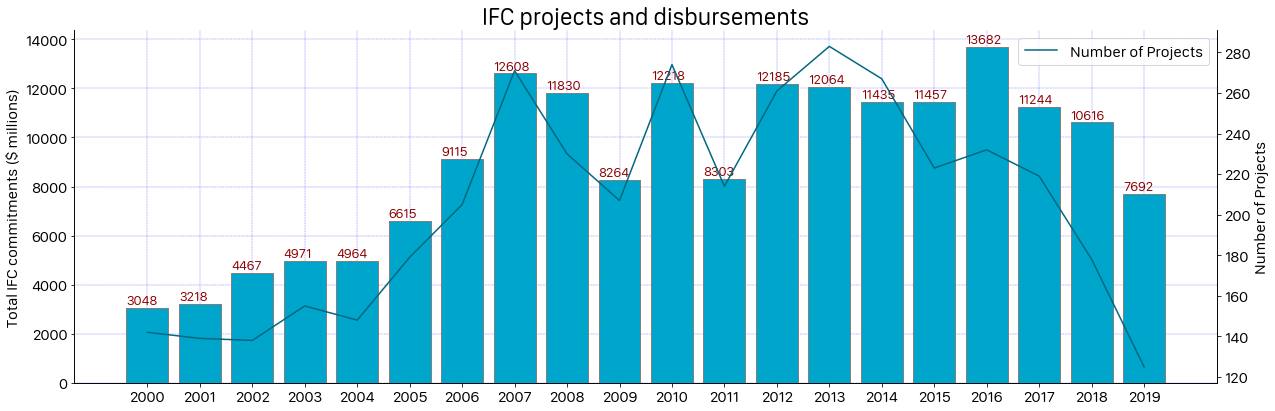

In [208]:
# Create chart for IFC projects and disbursements since 2000

plt.rc('figure', figsize=(18, 6))

# Choose custom font

fontpath = '/System/Library/Fonts/SFCompactRounded.ttf'
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots()

# Plot bar graph

ax1.bar(amnt['Year'], amnt['Amount_infl'], color ='#00A5CC', edgecolor = '#808080')
ax1.set_xticks([])                # to hide ticks on the second X-axis - top of the graph
ax1.set_ylabel('Total IFC commitments ($ millions)')


# Creating twin axes for precipitation as a bar graph on secondary XY axes
ax2 = ax1.twinx()

    
# Plot line graph

ax2.plot(no_projects['Year'], no_projects['Project Name'], color = '#00677F', label = 'Number of Projects')


# Plot bar graph text

for i, v in enumerate(amnt['Amount_infl']):
    ax1.text(i+1999.6 , v + 150 , str(v), color='#8B0000', size = '14')

# Make the y-axis label
ax2.set_ylabel('Number of Projects')
ax2.tick_params('y')

# Displaying grid for the Date axis
plt.xticks(np.arange(min(amnt['Year']), 2020, 1.0), rotation=45)

# Title
plt.title('IFC projects and disbursements', size = 24)

ax2.legend()

fig.tight_layout()

# Remove top spine

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add a grid

ax1.grid(color='b', ls = '-.', lw = 0.25)
ax1.grid(True)
ax1.set_axisbelow(True)

# Save

plt.savefig(path + 'Output/Project & Disbursements.png', bbox_inches='tight')

In [209]:
# Clean up investment string

final_inv['Investment'] = final_inv['Investment'].str.replace(' These investment figures are indicative',' ')

final_inv['Investment'].replace(r'<.*?>', '', regex=True, inplace = True)

final_inv['Investment'].replace(r'\(.*\)', '', regex=True, inplace = True)

# final_inv['Investment'] = final_inv['Investment'].str.replace(' million (USD)Product LineIFC Investment (million USD)',' ')

# final_inv['Investment'][1]

# .str.split(' ', expand = True, n = 10)

# 

# (USD)Product LineIFC Investment (million USD)Risk 

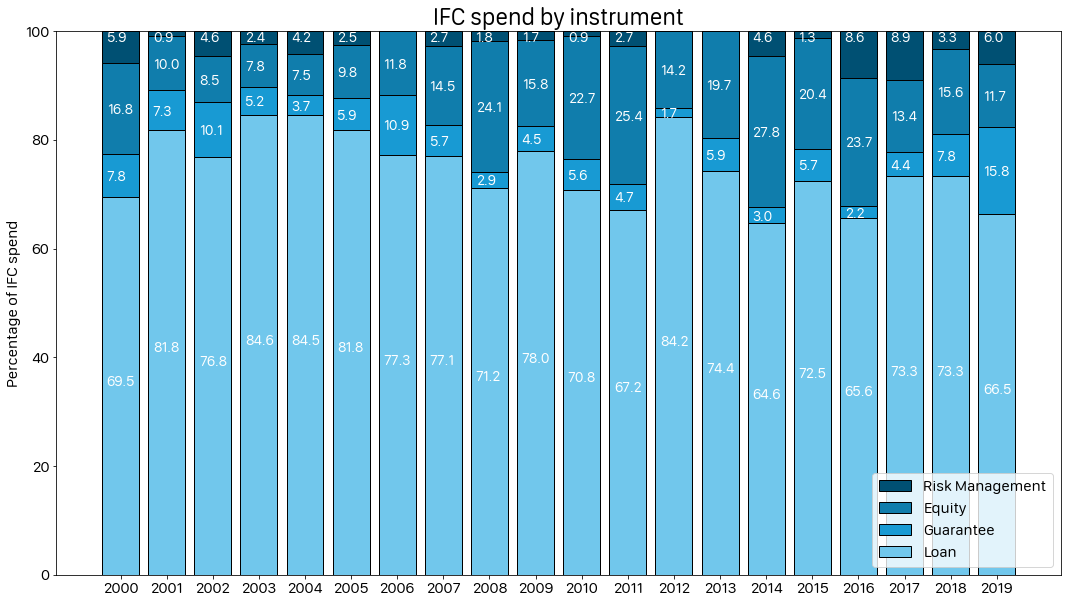

In [210]:
# Summarize data for chart on funding by instruments

instruments = pd.pivot_table(final_inv, values = 'Amount_infl', index = ['Year','Product Area Description'], aggfunc = 'sum')

instruments.reset_index(inplace = True)

instruments['Amount_infl'].fillna(0, inplace = True)

instruments['Amount_infl'].isna().sum()

# Calculate the percentage of total annual spend on each instrument per year

# Calculate total spend per year and assign this to a dictionary

totals = pd.DataFrame(instruments['Amount_infl'].groupby(instruments['Year']).sum()).reset_index()

inst_dict = dict(zip(totals['Year'], totals['Amount_infl']))

# Use this dictionary to populate a list with percent spent on each instrument per year

percentages_list = []
    
for i,j in instruments.iterrows():
    percent = (j[2]*100)/(inst_dict.get(j[0]))
    percentages_list.append(percent)
    
# Append list as a column to our dataframe
    
instruments['percent'] = pd.DataFrame(percentages_list)

# Reshape column into appropriate format

instruments_pct = instruments.pivot(index='Year', columns='Product Area Description', values = ['percent']).reset_index()

instruments_pct.columns = instruments_pct.columns.droplevel()
instruments_pct = pd.DataFrame(instruments_pct.to_records())

# Rename Year column and remove redundant column

instruments_pct.rename(columns = {'':'Year'}, inplace = True)
instruments_pct.drop(columns = ['index'], inplace = True)

# Fill missing values with 0

instruments_pct = instruments_pct.fillna(0)


# Create stacked bar chart

# Set up graph properties

barWidth = 0.8
instruments_pct['Year'] = instruments_pct['Year'].astype('int')
r = instruments_pct['Year']

#add colors
colors = ['#71c7ec', '#189ad3','#107dac','#005073']

plt.figure(figsize=(18,10))
ax1 = plt.bar(r, instruments_pct['Risk Management'], bottom=instruments_pct['Guarantee']+instruments_pct['Loan'] + instruments_pct['Equity'], color=colors[3], edgecolor = 'black', width=barWidth, label="Risk Management")
ax2 = plt.bar(r, instruments_pct['Equity'], bottom=instruments_pct['Guarantee']+instruments_pct['Loan'], color=colors[2], edgecolor = 'black', width=barWidth, label="Equity")
ax3 = plt.bar(r, instruments_pct['Guarantee'], bottom=instruments_pct['Loan'], color=colors[1], edgecolor = 'black', width=barWidth, label='Guarantee')
ax4 = plt.bar(r, instruments_pct['Loan'], color=colors[0], edgecolor = 'black', width=barWidth, label='Loan')

# Plot text

for i, v in enumerate(instruments_pct['Loan']):
    plt.text(i + 1999.70 , v/2  , str(round(v, 1)), color='#FFFFFF', size = '15')
    
for i, v in enumerate(instruments_pct['Loan']+instruments_pct['Guarantee']):
    plt.text(i + 1999.70 , v - (instruments_pct['Guarantee'][i]/2) - 1  , str(round(instruments_pct['Guarantee'][i], 1)), color='#FFFFFF', size = '15')

for i, v in enumerate(instruments_pct['Loan']+instruments_pct['Guarantee'] + instruments_pct['Equity']):
    plt.text(i + 1999.70 , v - (instruments_pct['Equity'][i]/2) - 1  , str(round(instruments_pct['Equity'][i], 1)), color='#FFFFFF', size = '15')
    
for i, v in enumerate(instruments_pct['Loan']+instruments_pct['Guarantee'] + instruments_pct['Equity'] + instruments_pct['Risk Management']):
    if instruments_pct['Risk Management'][i] != 0:
        plt.text(i + 1999.70 , 98 , str(round(instruments_pct['Risk Management'][i], 1)), color='#FFFFFF', size = '15')
    else:
        pass

plt.legend(loc = 'lower right')
plt.xticks(np.arange(2000, 2020, step=1))

plt.ylabel("Percentage of IFC spend")
plt.title("IFC spend by instrument", size = 24)

plt.savefig(path + 'Output/Instrument.png', bbox_inches='tight')

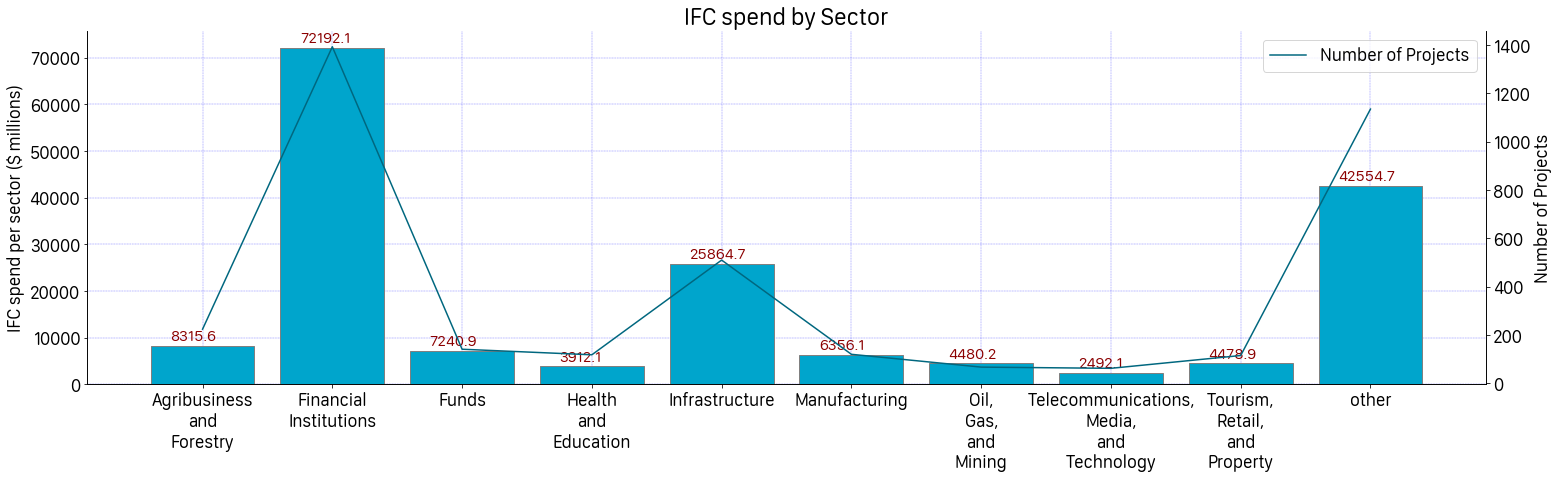

In [215]:
# Create chart for spend for different sectors

sectors = pd.DataFrame(final_inv['Amount_infl'].groupby(final_inv['Sector_y']).sum())

sectors['number'] = final_inv['Amount_infl'].groupby(final_inv['Sector_y']).count()

sectors.reset_index(inplace = True)

sectors['Sector_y'] = sectors['Sector_y'].str.replace(' ', '\n')

# Plot chart

plt.rc('figure', figsize=(22, 7))
fig, ax1 = plt.subplots()

plt.rcParams.update({'font.size': 18})

# Plot bar graph

ax1.bar(sectors['Sector_y'], sectors['Amount_infl'], color ='#00A5CC', edgecolor = '#808080')

# ax1.set_xticks([])                # to hide ticks on the second X-axis - top of the graph
ax1.set_ylabel('IFC spend per sector ($ millions)')


# Creating twin axes for precipitation as a bar graph on secondary XY axes
ax2 = ax1.twinx()

    
# Plot line graph

ax2.plot(sectors['Sector_y'], sectors['number'], color = '#00677F', label = 'Number of Projects')


# Plot bar graph text

for i, v in enumerate(sectors['Amount_infl']):
    ax1.text(i - .25 , v + 1050 , str(round(v, 1)), color='#8B0000', size = '16')

# Make the y-axis label
ax2.set_ylabel('Number of Projects')
ax2.tick_params('y')

ax1.set_xticks([])  
ax2.set_xticks([])  

# Title
plt.title('IFC spend by Sector', size = 24)

plt.xticks(sectors['Sector_y'], rotation=45)

# Legend

ax2.legend()

fig.tight_layout()

ax1.spines['top'].set_visible(False)

ax2.spines['top'].set_visible(False)

# Add a grid

ax1.grid(color='b', ls = '-.', lw = 0.25)
ax1.grid(True)
ax1.set_axisbelow(True)

# Save

plt.savefig(path + 'Output/Sectors.pdf')

In [212]:
sectors['Sector_y']

0                     Agribusiness\nand\nForestry
1                         Financial\nInstitutions
2                                           Funds
3                          Health\nand\nEducation
4                                  Infrastructure
5                                   Manufacturing
6                         Oil,\nGas,\nand\nMining
7    Telecommunications,\nMedia,\nand\nTechnology
8                Tourism,\nRetail,\nand\nProperty
9                                           other
Name: Sector_y, dtype: object

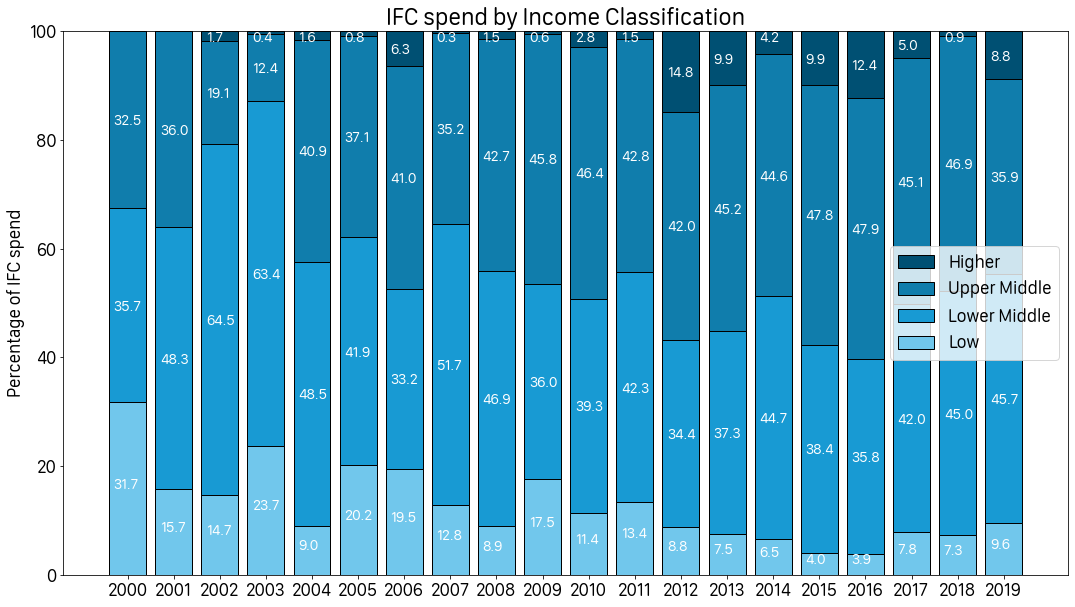

In [213]:
# Add in income status data

oghist = pd.read_excel(path + "/WB Data/OGHist.xlsx")

# Add in prefix to convert from wide to long format

keep_same = {'Code', 'Country'}

oghist.columns = ['{}{}'.format('' if c in keep_same else 'year_', c) for c in oghist.columns]

oghist = pd.wide_to_long(oghist, "year_", i="Code", j="Time").reset_index()

oghist.columns = ['Code','Year','Country','Income_class']

final_inv2 = final_inv.merge(oghist,  how='left', left_on=['Country_Code','Year'], right_on = ['Code','Year'])

final_inv2 = final_inv2.drop(['Code', 'Country_y'], axis=1)

income_class = pd.pivot_table(final_inv2, values = 'Amount_infl', index = ['Year','Income_class'], aggfunc = 'sum').reset_index()

# Shape it for stacked bar chart

income_class = income_class.pivot(index='Year', columns='Income_class', values='Amount_infl').reset_index()

income_class = pd.DataFrame(income_class.to_records()).reset_index()

income_class.drop(columns = ['..'], inplace = True)

income_class = income_class.iloc[:,2:]

income_class = income_class.fillna(0)

income_class['total'] = income_class.iloc[:, 1:].sum(axis=1)

# Prepare data for chart

income_class['Year'] = income_class['Year'].astype('int')
r = income_class['Year']

UM = (100 * income_class['UM'])/income_class['total']
LM = (100 * income_class['LM'])/income_class['total']
L = (100 * income_class['L'])/income_class['total']
H = (100 * income_class['H'])/income_class['total']


# Add colors
colors = ['#71c7ec', '#189ad3','#107dac','#005073']

plt.figure(figsize=(18,10))

ax1 = plt.bar(r, H, bottom=LM+L + UM, color=colors[3], edgecolor = 'black', width=barWidth, label="Higher")
ax2 = plt.bar(r, UM, bottom=LM+L, color=colors[2], edgecolor = 'black', width=barWidth, label="Upper Middle")
ax3 = plt.bar(r, LM, bottom=L, color=colors[1], edgecolor = 'black', width=barWidth, label='Lower Middle')
ax4 = plt.bar(r, L, color=colors[0], edgecolor = 'black', width=barWidth, label='Low')

# Plot text

for i, v in enumerate(L):
    plt.text(i + 1999.70 , v/2  , str(round(v, 1)), color='white', size = '15')
    
for i, v in enumerate(L+LM):
    plt.text(i + 1999.70 , v - (LM[i]/2) - 1  , str(round(LM[i], 1)), color='white', size = '15')

for i, v in enumerate(L+LM + UM):
    plt.text(i + 1999.70 , v - (UM[i]/2) - 1  , str(round(UM[i], 1)), color='white', size = '15')
    
for i, v in enumerate(L+LM + H + UM):
    if H[i] == 0:
        pass
    elif H[i] < 5:
        plt.text(i + 1999.70 , 98 , str(round(H[i], 1)) , color='white', size = '15')
    else:
        plt.text(i + 1999.70 , v - (H[i]/2) - 1 , str(round(H[i], 1)) , color='white', size = '15')

plt.legend(loc = 'center right')
plt.xticks(np.arange(2000, 2020, step=1))

plt.ylabel("Percentage of IFC spend")
plt.title("IFC spend by Income Classification", size = 24)

plt.savefig(path + 'Output/Income_Class.png', bbox_inches='tight')

In [214]:
H

0      0.000000
1      0.000000
2      1.717853
3      0.444147
4      1.613747
5      0.818534
6      6.332509
7      0.279877
8      1.478266
9      0.589756
10     2.845743
11     1.509656
12    14.790625
13     9.944562
14     4.166062
15     9.899011
16    12.366111
17     5.015520
18     0.911313
19     8.845877
dtype: float64

In [ ]:
<